In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.2 MB/s eta 0:00:0000:010:01


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [4]:
data_train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
data_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [6]:
store = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
holidays_events = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
transaction_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
transaction_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [9]:
data_train = data_train.merge(store, on = 'store_nbr')
data_train = data_train.merge(oil, on = 'date', how = 'left')
holidays_events = holidays_events.rename(columns = {'type': 'holiday_type'})
data_train = data_train.merge(holidays_events, on = 'date', how = 'left')

In [10]:
data_train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [11]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   int64  
 6   city          object 
 7   state         object 
 8   type          object 
 9   cluster       int64  
 10  dcoilwtico    float64
 11  holiday_type  object 
 12  locale        object 
 13  locale_name   object 
 14  description   object 
 15  transferred   object 
dtypes: float64(2), int64(4), object(10)
memory usage: 396.1+ MB


In [12]:
data_train.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type                  0
cluster               0
dcoilwtico       955152
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dtype: int64

In [13]:
missing_percentages = data_train.isnull().sum() / data_train.shape[0]
missing_percentages

id              0.000000
date            0.000000
store_nbr       0.000000
family          0.000000
sales           0.000000
onpromotion     0.000000
city            0.000000
state           0.000000
type            0.000000
cluster         0.000000
dcoilwtico      0.312719
holiday_type    0.835473
locale          0.835473
locale_name     0.835473
description     0.835473
transferred     0.835473
dtype: float64

In [14]:
cols = missing_percentages > 0.3
data_train = data_train.loc[:, ~cols.values]
data_train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [15]:
data_train.duplicated().any()

True

In [16]:
np.sum(data_train.duplicated())

53460

In [17]:
data_train = data_train.drop_duplicates()
data_train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [18]:
data_train.describe()

,id,store_nbr,sales,onpromotion,cluster
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00,8.481481e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01,4.649735e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00,1.300000e+01
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01


In [19]:
dates = pd.date_range(start = min(data_train.date), end = max(data_train.date))
len(dates)

1688

In [20]:
group_data = data_train.groupby('type')['sales']

f, p_value = stats.f_oneway(*[group_data.get_group(t) for t in data_train.type.unique()])
print(p_value)
print(f)

0.0
17766.023730362205


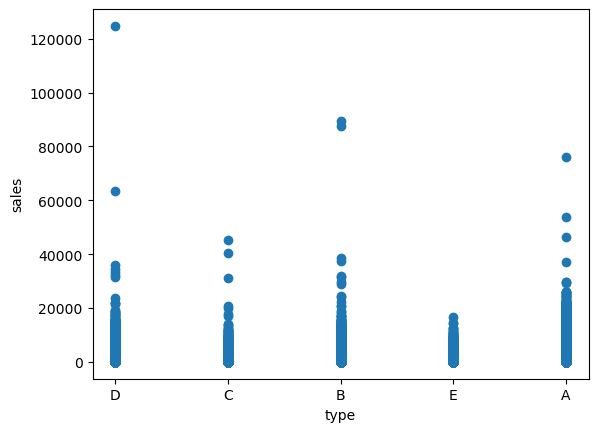

In [21]:
plt.scatter(data_train.type, data_train.sales)

plt.xlabel('type')
plt.ylabel('sales')

plt.show()

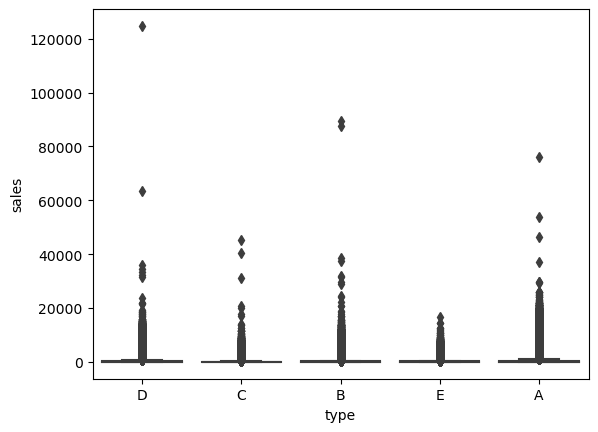

In [22]:
sns.boxplot(x = 'type', y = 'sales', data = data_train)
plt.show()

In [23]:
len(data_train.family.unique())

33

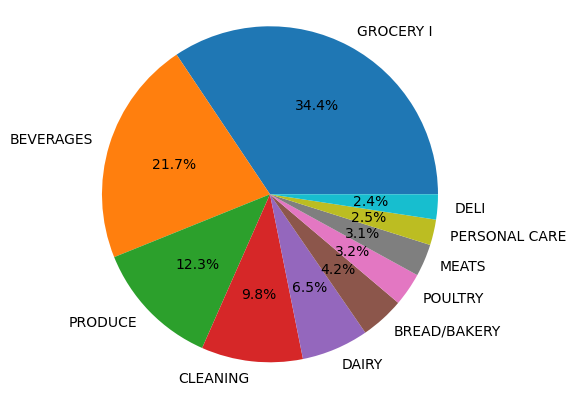

In [24]:
family_sales = data_train.groupby('family')['sales'].sum()
family_sales = family_sales.sort_values(ascending = False)

plt.pie(family_sales.head(10), autopct = '%1.1f%%', labels = family_sales.head(10).index)

plt.axis('equal')  
plt.show()

In [25]:
cor, p_value = pearsonr(data_train.onpromotion.to_numpy(), data_train.sales.to_numpy())

print(cor)
print(p_value)

0.42792320481209284
0.0


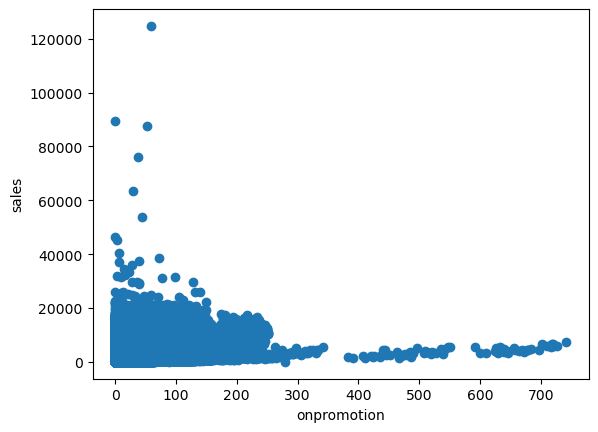

In [26]:
plt.scatter(data_train.onpromotion, data_train.sales)

plt.xlabel('onpromotion')
plt.ylabel('sales')

plt.show()

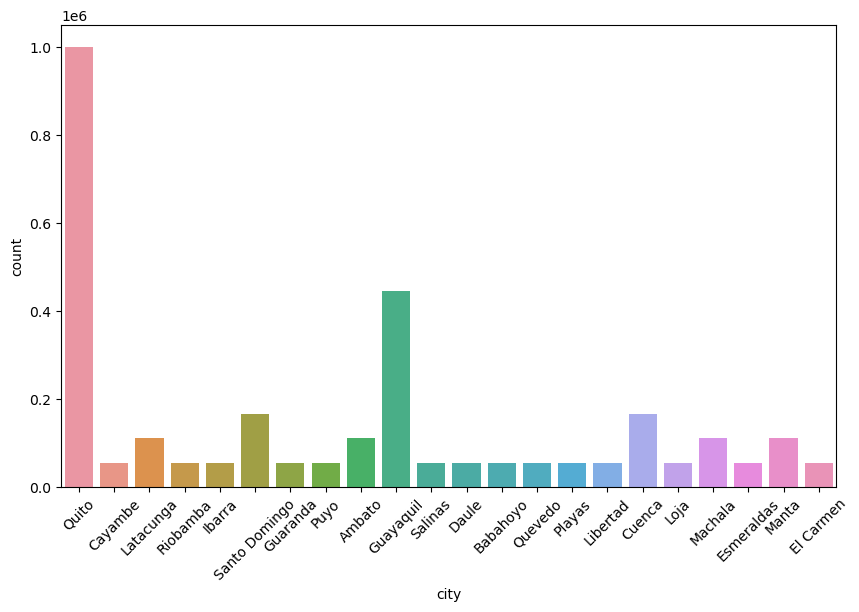

In [27]:
plt.figure(figsize=(10, 6)) 

sns.countplot(data = data_train, x = 'city')
plt.xlabel('city')
plt.ylabel('count')
plt.xticks(rotation=45)

plt.show()

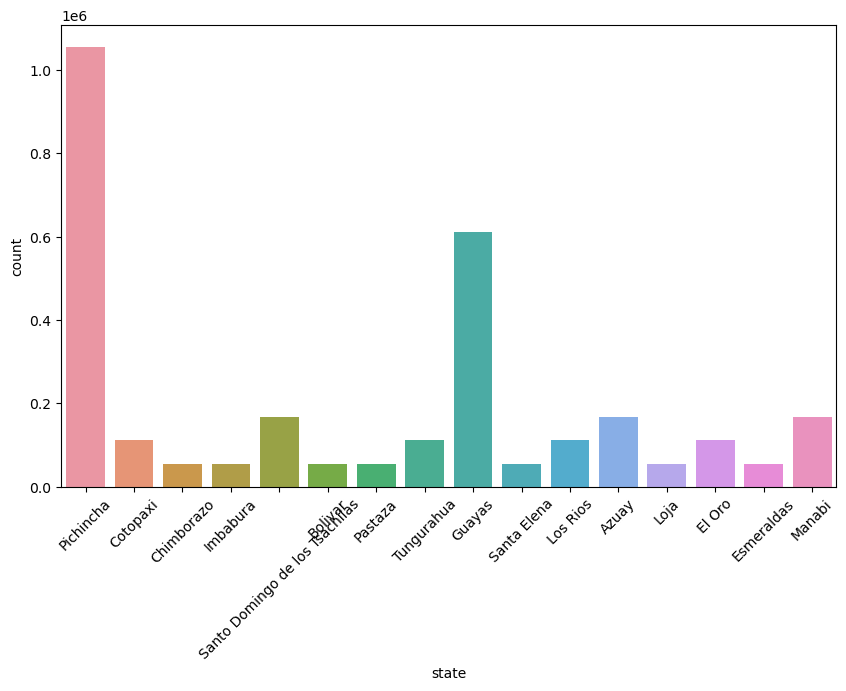

In [28]:
plt.figure(figsize=(10, 6)) 

sns.countplot(data = data_train, x = 'state')
plt.xlabel('state')
plt.ylabel('count')
plt.xticks(rotation=45)

plt.show()

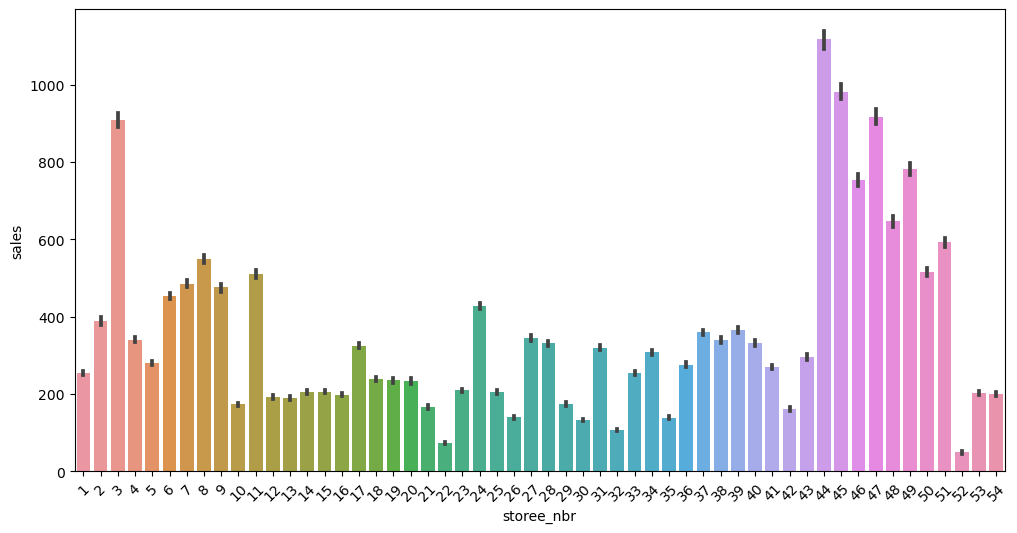

In [29]:
store_sales = data_train.groupby('store_nbr')['sales'].sum().reset_index()
store_sales = store_sales.sort_values('sales', ascending = False)

plt.figure(figsize=(12, 6)) 

sns.barplot(data = data_train, x = 'store_nbr', y = 'sales')
plt.xlabel('storee_nbr')
plt.ylabel('sales')
plt.xticks(rotation=45)

plt.show()

In [30]:
data_train.date = pd.to_datetime(data_train.date)
data_train.loc[:, 'month'] = data_train.date.dt.month
data_train.loc[:, 'year'] = data_train.date.dt.year

data_train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,month,year
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,1,2013
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,1,2013
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,1,2013
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,1,2013
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,1,2013


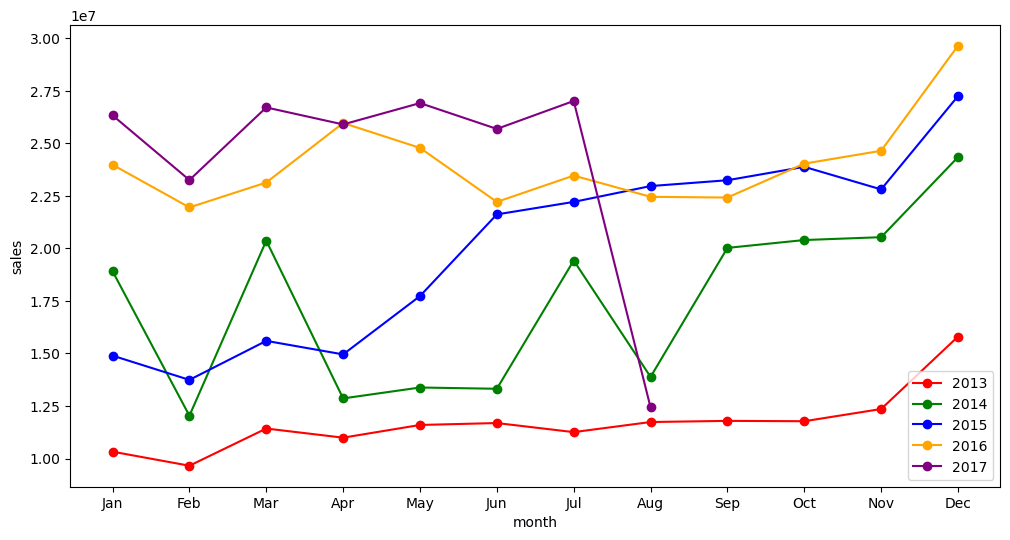

In [31]:
month_sales = data_train.groupby(['year', 'month'])['sales'].sum().reset_index()

years = data_train.year.unique()
colors = itertools.cycle(['red', 'green', 'blue', 'orange', 'purple'])

plt.figure(figsize=(12, 6)) 

for year in years:
    year_data = month_sales.loc[month_sales.year == year, :]
    plt.plot(year_data.month, year_data.sales, marker = 'o', color = next(colors), 
             label = str(year))

plt.xlabel('month')
plt.ylabel('sales')  
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1, 13), month_names)
plt.legend(loc = 'best')

plt.show()

In [32]:
data_train = data_train.groupby('date')[['sales', 'onpromotion']].sum().reset_index()
data_train.head()

,date,sales,onpromotion
0,2013-01-01,2511.618999,0
1,2013-01-02,496092.417944,0
2,2013-01-03,361461.231124,0
3,2013-01-04,354459.677093,0
4,2013-01-05,477350.121229,0


In [33]:
data_train.shape

(1684, 3)

In [34]:
dates = pd.date_range(start = min(data_train.date), end = max(data_train.date))
len(dates)

1688

In [35]:
data_train.date.dt.date

0       2013-01-01
1       2013-01-02
2       2013-01-03
3       2013-01-04
4       2013-01-05
           ...    
1679    2017-08-11
1680    2017-08-12
1681    2017-08-13
1682    2017-08-14
1683    2017-08-15
Name: date, Length: 1684, dtype: object

In [36]:
dates = pd.to_datetime(dates) 

tmp = [d for d in dates if d not in data_train.date.dt.date.values]
tmp = pd.to_datetime(tmp)
tmp

/tmp/ipykernel_32/433320053.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  tmp = [d for d in dates if d not in data_train.date.dt.date.values]


DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

In [37]:
df = pd.DataFrame({'date': tmp, 'sales': np.zeros(4), 'onpromotion': np.zeros(4)})
df

,date,sales,onpromotion
0,2013-12-25,0.0,0.0
1,2014-12-25,0.0,0.0
2,2015-12-25,0.0,0.0
3,2016-12-25,0.0,0.0


In [38]:
data_train = pd.concat([data_train, df])
data_train = data_train.sort_values('date').reset_index()
data_train.tail()

,index,date,sales,onpromotion
1683,1679,2017-08-11,826373.722022,14179.0
1684,1680,2017-08-12,792630.535079,8312.0
1685,1681,2017-08-13,865639.677471,9283.0
1686,1682,2017-08-14,760922.406081,8043.0
1687,1683,2017-08-15,762661.935939,10605.0


In [39]:
data_train.sales.autocorr()

0.7341867672440311

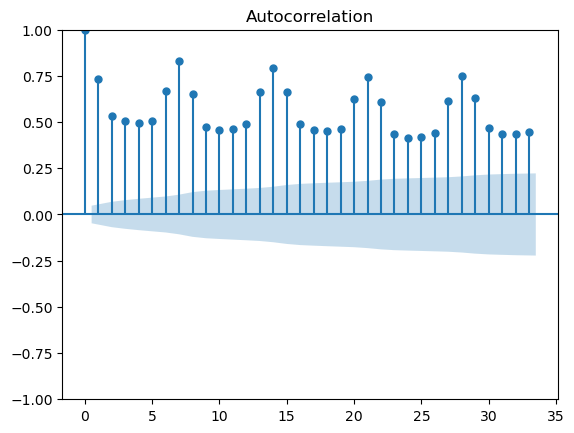

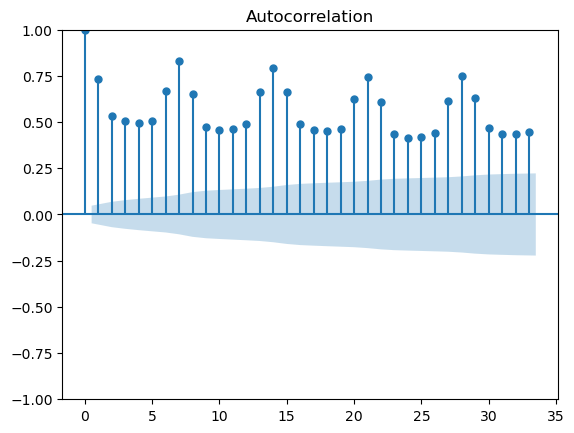

In [40]:
plot_acf(data_train.sales, alpha = 0.05)

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


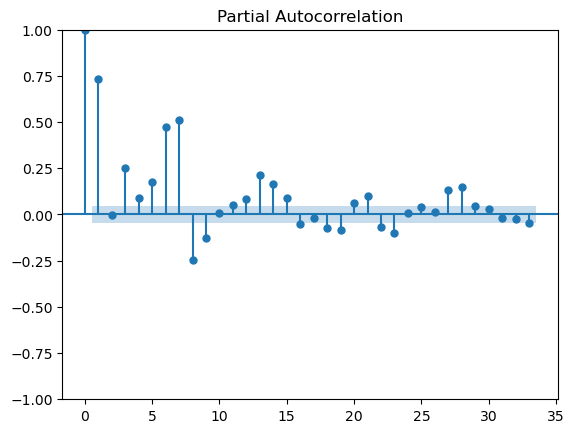

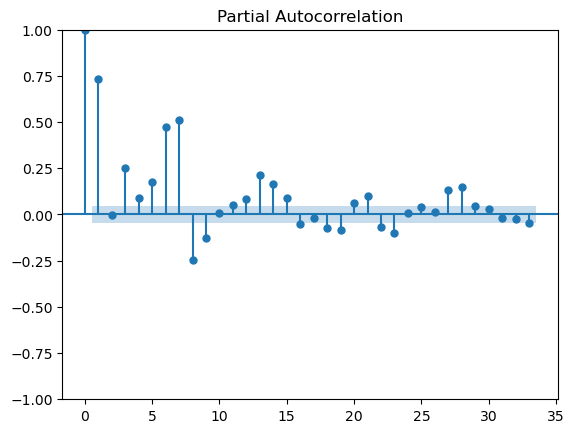

In [41]:
plot_pacf(data_train.sales, alpha = 0.05)

In [42]:
adfuller(data_train.sales)

(-2.5714136301716985,
 0.09905058352484253,
 22,
 1665,
 {'1%': -3.434283579780684,
  '5%': -2.863277451883613,
  '10%': -2.5676949772294817},
 43145.26230772958)

In [43]:
kpss(data_train.sales)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(5.816378252200251,
 0.01,
 24,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [44]:
from pmdarima.arima import ndiffs

In [45]:
ndiffs(data_train.sales,  test="adf")

0

In [46]:
tmp = data_train.sales.diff()
tmp = tmp.dropna()
print(tmp.head())
print(tmp.shape)

1    493580.798945
2   -134631.186820
3     -7001.554031
4    122890.444136
5     42345.279859
Name: sales, dtype: float64
(1687,)


In [47]:
adfuller(tmp)

(-11.31158291004286,
 1.2352337993923581e-20,
 25,
 1661,
 {'1%': -3.4342930672797065,
  '5%': -2.8632816397229064,
  '10%': -2.567697207194407},
 43097.7529138101)

In [48]:
kpss(tmp)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.06277531857785063,
 0.1,
 54,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

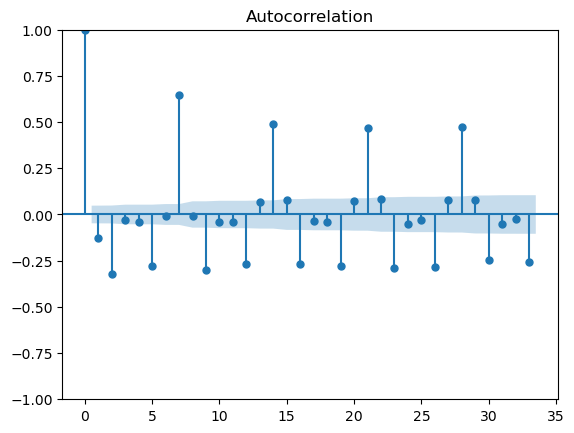

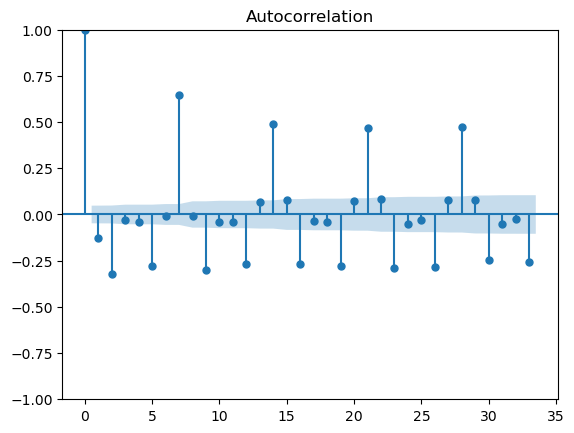

In [49]:
plot_acf(tmp, alpha = 0.05)

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


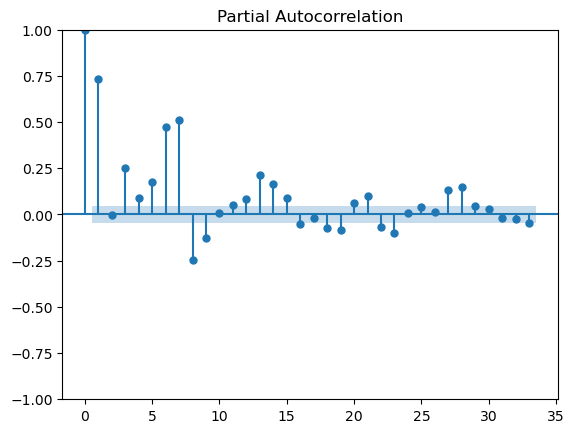

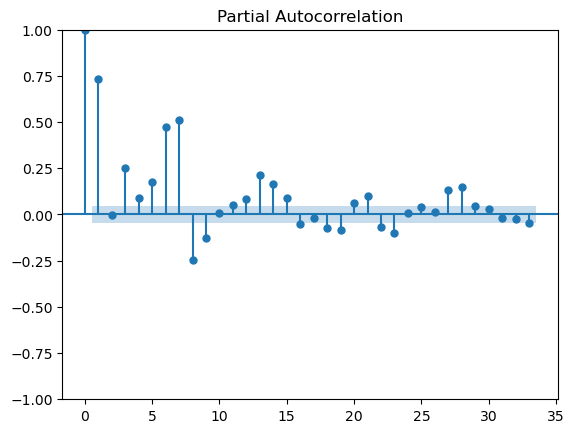

In [50]:
plot_pacf(data_train.sales, alpha = 0.05)

In [51]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error

In [52]:
final_train = data_train.sales.values.astype('float64')

In [52]:
model = ARIMA(final_train, order = (7, 1, 2))
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1688
Model:                 ARIMA(7, 1, 2)   Log Likelihood              -21996.648
Date:                Thu, 13 Jul 2023   AIC                          44013.296
Time:                        06:53:20   BIC                          44067.603
Sample:                             0   HQIC                         44033.408
                               - 1688                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2886      0.066     -4.386      0.000      -0.418      -0.160
ar.L2         -0.5181      0.067     -7.785      0.000      -0.649      -0.388
ar.L3         -0.3657      0.059     -6.148      0.000      -0.482      -0.249
ar.L4         -0.3872      0.055     -6.998      0.000      -0.496      -0.279
ar.L5         -0.4102      0.052     -7.883      0.000      -0.512      -0.308
ar.L6         -0.2582      0.054     -4.777      0.000      -0.364      -0.152
ar.L7          0.3088      0.046      6.758      0.000       0.219       0.398
ma.L1         -0.2243      0.065     -3.473      0.001      -0.351      -0.098
ma.L2          0.1250      0.043      2.911      0.004       0.041       0.209
sigma2      1.245e+10   9.49e-11   1.31e+20      0.000    1.24e+10    1.24e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             36361.92
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                            -1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.42e+34. Standard errors may be unstable.
"""

In [57]:
model =  auto_arima(final_train, freq = 'D')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1688
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -22403.632
Date:                Fri, 14 Jul 2023   AIC                          44813.263
Time:                        03:28:18   BIC                          44829.555
Sample:                             0   HQIC                         44819.297
                               - 1688                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4556      0.012    -38.822      0.000      -0.479      -0.433
ma.L2         -0.4741      0.011    -44.796      0.000      -0.495      -0.453
sigma2       1.94e+10   2.49e-13    7.8e+22      0.000    1.94e+10    1.94e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              3773.46
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               2.71   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.33e+37. Standard errors may be unstable.
"""

In [58]:
model = SimpleExpSmoothing(final_train)
result = model.fit()

result.summary()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,endog,No. Observations:,1688
Model:,SimpleExpSmoothing,SSE,41898935225694.891
Optimized:,True,AIC,40406.249
Trend:,None,BIC,40417.112
Seasonal:,None,AICC,40406.273
Seasonal Periods:,None,Date:,"Fri, 14 Jul 2023"
Box-Cox:,False,Time:,03:28:45
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1086047,alpha,True
initial_level,2511.6190,l.0,True


In [59]:
model = Holt(final_train)
result = model.fit()

result.summary()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,endog,No. Observations:,1688
Model:,Holt,SSE,53793535691390.250
Optimized:,True,AIC,40832.069
Trend:,Additive,BIC,40853.794
Seasonal:,None,AICC,40832.119
Seasonal Periods:,None,Date:,"Fri, 14 Jul 2023"
Box-Cox:,False,Time:,03:29:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7828571,alpha,True
smoothing_trend,0.0618045,beta,True


In [ ]:
model = ExponentialSmoothing(final_train, trend = 'mul', seasonal = None)
result = model.fit()

result.summary()